<a href="https://colab.research.google.com/github/ldkmdcj/CI/blob/main/Covid_19_Image_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## COVID19 IMAGE DATASET - CLASSIFICATION with TRANSFER LEARNING (RESNET 50)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import numpy as np
import keras
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Rescaling, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator,load_img
from keras.models import Sequential
from time import time
from matplotlib.pyplot import imshow
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
from glob import glob
from collections import Counter

In [ ]:
!ls "/content/drive/My Drive/Colab Notebooks/Covid19-dataset/"
!ls "/content/drive/My Drive/Colab Notebooks/Covid19-dataset/train/"

test  train
 Covid	 Normal  'Viral Pneumonia'


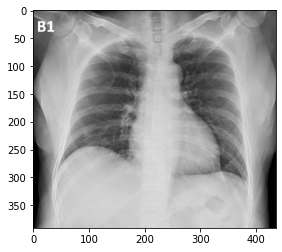

In [ ]:
%matplotlib inline
pil_im = Image.open('/content/drive/My Drive/Colab Notebooks/Covid19-dataset/test/Covid/094.png', 'r')
imshow(np.asarray(pil_im))

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
# DATASOURCE

In [ ]:
image_size = (224, 224)
batch_size = 10

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/My Drive/Colab Notebooks/Covid19-dataset/train/",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/My Drive/Colab Notebooks/Covid19-dataset/test/",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

train_ds = train_ds.prefetch(buffer_size=5)
test_ds = test_ds.prefetch(buffer_size=5)

Found 251 files belonging to 3 classes.
Found 66 files belonging to 3 classes.


In [ ]:
# MODEL

In [ ]:
model = keras.Sequential()
model.add(Rescaling(scale=(1./255),
                    offset=-1, 
                    input_shape=(224, 224, 3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(256, (3, 3), activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 54, 54, 64)        0

In [ ]:
# TRAINING

In [ ]:
epochs = 200

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5, restore_best_weights=True)

h = model.fit(
        train_ds,
        epochs=epochs, 
        validation_data=test_ds,
        callbacks = [es]
)

Epoch 1/200
26/26 [==============================] - 45s 955ms/step - loss: 1.1415 - accuracy: 0.4183 - val_loss: 1.0911 - val_accuracy: 0.3939
Epoch 2/200
26/26 [==============================] - 4s 119ms/step - loss: 0.8745 - accuracy: 0.5857 - val_loss: 0.7395 - val_accuracy: 0.6515
Epoch 3/200
26/26 [==============================] - 4s 120ms/step - loss: 0.5792 - accuracy: 0.7928 - val_loss: 0.3956 - val_accuracy: 0.8636
Epoch 4/200
26/26 [==============================] - 4s 116ms/step - loss: 0.6547 - accuracy: 0.7570 - val_loss: 0.4143 - val_accuracy: 0.8333
Epoch 5/200
26/26 [==============================] - 4s 120ms/step - loss: 0.3782 - accuracy: 0.8566 - val_loss: 0.2695 - val_accuracy: 0.9091
Epoch 6/200
26/26 [==============================] - 4s 120ms/step - loss: 0.3256 - accuracy: 0.8765 - val_loss: 0.3983 - val_accuracy: 0.8939
Epoch 7/200
26/26 [==============================] - 4s 119ms/step - loss: 0.2432 - accuracy: 0.9363 - val_loss: 0.2899 - val_accuracy: 0.893

In [ ]:
# TRANSFER LEARNING - RESNET 50

In [ ]:
base_model = tf.keras.applications.resnet.ResNet50(
    weights='imagenet',  
    input_shape=(224, 224, 3),
    include_top=False)  

base_model.trainable = False
inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(128, activation='relu')(x)
outputs = keras.layers.Dense(3, activation='softmax')(x)

model = keras.Model(inputs,outputs)

94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_3 (Dense)             (None, 128)               262272    
                                                                 
 dense_4 (Dense)             (None, 3)                 387       
                                                                 
Total params: 23,850,371
Trainable params: 262,659
Non-trainable params: 23,587,712
___________________________________________

In [ ]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

epochs = 60

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10, restore_best_weights=True)

h = model.fit(
        train_ds,
        epochs=epochs, 
        validation_data=test_ds,
        callbacks = [es]
)

Epoch 1/60
26/26 [==============================] - 9s 181ms/step - loss: 0.9478 - accuracy: 0.7052 - val_loss: 0.5082 - val_accuracy: 0.7727
Epoch 2/60
26/26 [==============================] - 5s 138ms/step - loss: 0.2196 - accuracy: 0.9124 - val_loss: 0.3168 - val_accuracy: 0.8788
Epoch 3/60
26/26 [==============================] - 5s 140ms/step - loss: 0.1591 - accuracy: 0.9243 - val_loss: 0.1095 - val_accuracy: 0.9848
Epoch 4/60
26/26 [==============================] - 4s 135ms/step - loss: 0.0483 - accuracy: 0.9920 - val_loss: 0.1059 - val_accuracy: 0.9697
Epoch 5/60
26/26 [==============================] - 4s 136ms/step - loss: 0.0324 - accuracy: 0.9960 - val_loss: 0.0818 - val_accuracy: 0.9848
Epoch 6/60
26/26 [==============================] - 5s 161ms/step - loss: 0.0273 - accuracy: 0.9960 - val_loss: 0.2507 - val_accuracy: 0.8636
Epoch 7/60
26/26 [==============================] - 4s 132ms/step - loss: 0.0302 - accuracy: 1.0000 - val_loss: 0.0738 - val_accuracy: 0.9848
Epoch 

In [ ]:
# MODEL ACCURACY

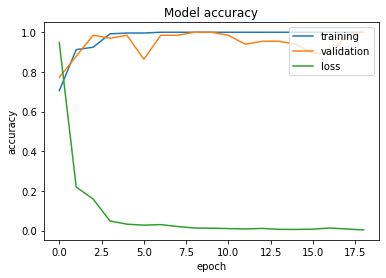

In [ ]:
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.plot(h.history['loss'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation','loss'], loc='upper right')
plt.show()

In [ ]:
# CONFUSION MATRIX

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00        20

    accuracy                           1.00        66
   macro avg       1.00      1.00      1.00        66
weighted avg       1.00      1.00      1.00        66



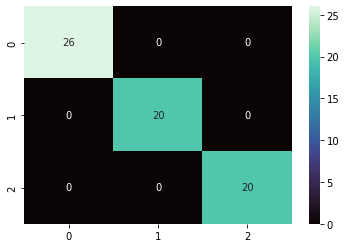

In [ ]:
results = np.concatenate([(y, model.predict(x=x)) for x, y in test_ds], axis=1)

predictions = np.argmax(results[0], axis=1)
labels = np.argmax(results[1], axis=1)

cf_matrix = confusion_matrix(labels, predictions)

sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="mako")

print(classification_report(labels, predictions, digits = 2))

In [ ]:
# MODEL SAVE

In [ ]:
model.save("Covid19-Image Classification.h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
